<a href="https://colab.research.google.com/github/aekanun2020/2022-PEA-ML-sklearn-Spark-/blob/main/K_sklearn_Cassification_Pipeline_Prediciton_of_Loan_Payment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

In [2]:
! wget https://storage.googleapis.com/2022oct23/LoanStats_web.csv

--2022-11-08 22:53:47--  https://storage.googleapis.com/2022oct23/LoanStats_web.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1160243241 (1.1G) [text/csv]
Saving to: ‘LoanStats_web.csv’

LoanStats_web.csv   100%[===================>]   1.08G  20.3MB/s    in 58s     

2022-11-08 22:54:46 (19.1 MB/s) - ‘LoanStats_web.csv’ saved [1160243241/1160243241]



# **2. Data Profiling and Cleansing**

In [3]:
loans = pd.read_csv('LoanStats_web.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,19,55,112,123,124,125,128,129,130,133,138,139,140) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
## นับจำนวน columns และจำนวน rows รวมถึง data type
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432466 entries, 0 to 1432465
Columns: 144 entries, id to settlement_term
dtypes: float64(106), object(38)
memory usage: 1.5+ GB


In [5]:
## preview ดูรายละเอียดข้อมูล จำนวน 5 rows

loans.sample(5).transpose()

,1068426,226635,24954,1273817,498861
id,NaN,NaN,NaN,NaN,NaN
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,7500.0,2400.0,20000.0,21950.0,5000.0
funded_amnt,7500.0,2400.0,20000.0,21950.0,5000.0
funded_amnt_inv,7500.0,2400.0,20000.0,21950.0,5000.0
term,36 months,36 months,60 months,36 months,36 months
int_rate,6.11%,9.16%,21.97%,15.02%,11.39%
installment,228.54,76.5,552.04,761.12,164.62
grade,A,B,E,C,B
sub_grade,A1,B2,E4,C3,B3


In [6]:
## แสดงจำนวนของค่าที่แตกต่างกันใน loan_status โดยนับ null ด้วย

loans['loan_status'].value_counts(dropna=False)

Current               663690
Fully Paid            583755
Charged Off           152999
Late (31-120 days)     19455
In Grace Period         6136
Late (16-30 days)       4986
Default                 1419
NaN                       26
Name: loan_status, dtype: int64

In [7]:
## เลือกเฉพาะ rows ข้อมูลที่มี loan_staus เป็น Fully Paid และ Charged Off

loans = loans[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [8]:
## แสดงจำนวนของค่าที่แตกต่างกันใน loan_status โดยไม่นับ null ด้วย
loans['loan_status'].value_counts()

### จากผลการวิเคราะห์ สรุปได้ว่ามี imbalance classes

Fully Paid     583755
Charged Off    152999
Name: loan_status, dtype: int64

In [9]:
## ดูจำนวน row และจำนวน columns ของข้อมูลหลังจากเลือกมาเฉพาะ Fully Paid กับ Charge Off

loans.shape

(736754, 144)

In [10]:
## ประกาศตัวแปร

nullCols_list = []
outlierCols_list = []
highScaleCols_list = []
highDispersionCols_list = []
highCorrCols_list = []
lowCorrCols_list = []
numCol_list = []
catCol_list = []

## รายชื่อ Columns ที่ไม่เกี่ยวข้องกับการวิเคราะห์ฯ ซึ่งได้จากการสอบถามผู้เชี่ยวชาญทางธุรกิจ 
## (Requirement from business perspective)

temp_IgnoredCols_list = ['total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'\
       'delinq_2yrs', 'inq_last_6mths','out_prncp', 'out_prncp_inv','total_il_high_credit_limit'
       ]

## **2.1 Null and Dispersion Profiling with Univariate Analysis**

In [11]:
loans.isnull().any()

id                                             True
member_id                                      True
loan_amnt                                     False
funded_amnt                                   False
funded_amnt_inv                               False
term                                          False
int_rate                                      False
installment                                   False
grade                                         False
sub_grade                                     False
emp_title                                      True
emp_length                                     True
home_ownership                                False
annual_inc                                    False
verification_status                           False
issue_d                                       False
loan_status                                   False
pymnt_plan                                    False
url                                            True
desc        

In [12]:
## แสดงจำนวนของค่าที่แตกต่างกันใน loan_status โดยนับ null ด้วย
### loans['loan_status'].value_counts(dropna=False)

In [13]:
## คำนวณ percentage ของ null ในแต่ละ column

missing_fractions = loans.isnull().mean().sort_values(ascending=False)

In [14]:
## แสดงผลการคำนวณ percentage ของ null ในแต่ละ column
missing_fractions.head(100)

id                                            1.000000
next_pymnt_d                                  1.000000
url                                           1.000000
member_id                                     1.000000
desc                                          0.999974
orig_projected_additional_accrued_interest    0.994470
payment_plan_start_date                       0.991767
hardship_type                                 0.991767
hardship_reason                               0.991767
hardship_status                               0.991767
hardship_amount                               0.991767
hardship_start_date                           0.991767
hardship_end_date                             0.991767
deferral_term                                 0.991767
hardship_length                               0.991767
hardship_loan_status                          0.991767
hardship_payoff_balance_amount                0.991767
hardship_last_payment_amount                  0.991767
hardship_d

In [15]:
#loans.isnull().sum().sort_values(ascending=False)

In [16]:
nullCols_list = missing_fractions[missing_fractions > 0.4].index.tolist()
sorted(nullCols_list)

['annual_inc_joint',
 'debt_settlement_flag_date',
 'deferral_term',
 'desc',
 'dti_joint',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'id',
 'member_id',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'next_pymnt_d',
 'orig_projected_additional_accrued_interest',
 'payment_plan_start_date',
 'revol_bal_joint',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_mths_since_last_major_derog',
 'sec_app_num_rev_accts',
 'sec_app_open_acc',
 'sec_app_open_act_il',
 'sec_app_revol_util',
 'settlement_amount',
 'settlement_date',
 'settlement_percentage',
 'settlement_sta

In [17]:
# เลือกชื่อ Columns ที่ไม่ได้อยู่ใน nullCols_list และไม่ได้อยู่ใน temp_IgnoredCols_list

selectedCols_list = [x for x in loans.columns if ((x not in nullCols_list)&(x not in temp_IgnoredCols_list))]


loans = loans[selectedCols_list]

In [18]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736754 entries, 0 to 1432462
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             736754 non-null  float64
 1   funded_amnt           736754 non-null  float64
 2   funded_amnt_inv       736754 non-null  float64
 3   term                  736754 non-null  object 
 4   int_rate              736754 non-null  object 
 5   installment           736754 non-null  float64
 6   grade                 736754 non-null  object 
 7   sub_grade             736754 non-null  object 
 8   emp_title             681958 non-null  object 
 9   emp_length            684608 non-null  object 
 10  home_ownership        736754 non-null  object 
 11  annual_inc            736754 non-null  float64
 12  verification_status   736754 non-null  object 
 13  issue_d               736754 non-null  object 
 14  loan_status           736754 non-null  object 
 15 

***----------สิ่งที่ได้รับตอนนี้ คือ Dataframe มีขนาดเล็กลง (Smaller Feature Space และข้อมูลเกี่ยวข้องกับการวิเคราะห์ข้อมูลมากขึ้น (Relevance)----------***

In [19]:
null_series = loans.isnull().any()

In [20]:
nullCols_list

['id',
 'next_pymnt_d',
 'url',
 'member_id',
 'desc',
 'orig_projected_additional_accrued_interest',
 'payment_plan_start_date',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'deferral_term',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'hardship_dpd',
 'sec_app_mths_since_last_major_derog',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_percentage',
 'settlement_amount',
 'settlement_date',
 'settlement_term',
 'verification_status_joint',
 'dti_joint',
 'annual_inc_joint',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog'

In [21]:
nullCols_list = null_series[null_series].index.tolist()

In [22]:
nullCols_list

['emp_title',
 'emp_length',
 'title',
 'zip_code',
 'dti',
 'revol_util',
 'last_pymnt_d',
 'last_credit_pull_d']

***----------สิ่งที่ได้รับตอนนี้ คือ ชื่อ Columns ที่มี Null Profile----------***

In [23]:
# เลือกชื่อ Columns ที่เป็น Numerical Variables

numCol_list = loans.select_dtypes('number').columns

In [24]:
# คำนวณค่าสถิติจาก Columns ที่เป็น Numerical

loans[numCol_list].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,736754.0,14504.612089,9243.765872,1000.00,7200.000000,12000.000000,20000.000000,4.000000e+04
funded_amnt,736754.0,14504.587657,9243.765737,1000.00,7200.000000,12000.000000,20000.000000,4.000000e+04
funded_amnt_inv,736754.0,14499.239053,9241.323685,725.00,7200.000000,12000.000000,20000.000000,4.000000e+04
installment,736754.0,446.576084,282.946410,30.12,238.110000,370.480000,602.300000,1.715420e+03
annual_inc,736754.0,79498.492644,78094.751870,0.00,48000.000000,67000.000000,95000.000000,9.573072e+06
dti,736282.0,18.711086,13.794251,-1.00,11.890000,17.820000,24.500000,9.990000e+02
delinq_2yrs,736754.0,0.327729,0.900894,0.00,0.000000,0.000000,0.000000,2.900000e+01
open_acc,736754.0,11.757615,5.773028,0.00,8.000000,11.000000,15.000000,8.600000e+01
pub_rec,736754.0,0.247868,0.664559,0.00,0.000000,0.000000,0.000000,6.100000e+01
revol_bal,736754.0,16101.814410,22819.350827,0.00,5628.000000,10694.000000,19172.000000,1.137891e+06


In [25]:
# เลือกชื่อ Columns ที่เป็น categorical variables (String)

catCol_list = loans.select_dtypes('object').columns

In [26]:
# คำนวณค่าสถิติจาก Columns ที่เป็น String

loans[catCol_list].describe().transpose()

,count,unique,top,freq
term,736754,2,36 months,580853
int_rate,736754,258,11.49%,33561
grade,736754,7,C,222414
sub_grade,736754,35,B5,54266
emp_title,681958,144235,Teacher,13298
emp_length,684608,11,10+ years,247496
home_ownership,736754,5,MORTGAGE,361978
verification_status,736754,3,Source Verified,306372
issue_d,736754,30,Mar-2017,86864
loan_status,736754,2,Fully Paid,583755


In [27]:
highCardinality_list = ['emp_title','revol_util','earliest_cr_line','zip_code']

In [28]:
loans['emp_length'].value_counts()

10+ years    247496
2 years       68493
3 years       60901
< 1 year      55912
1 year        49886
5 years       45876
4 years       44489
6 years       32116
8 years       28125
9 years       26475
7 years       24839
Name: emp_length, dtype: int64

In [29]:
## คำนวนค่า Coefficient of Variance เพื่อดูว่า Columns ไหน Dispersion มากน้อยกว่ากัน

describe_pd = loans[numCol_list].describe().transpose()

describe_pd.assign(cv=lambda x: ((100/x['mean'])*x['std']))[['cv','mean','std']].sort_values('cv',ascending=False)

,cv,mean,std
delinq_2yrs,274.889447,0.327729,0.900894
pub_rec,268.109730,0.247868,0.664559
revol_bal,141.719127,16101.814410,22819.350827
annual_inc,98.234255,79498.492644,78094.751870
dti,73.722342,18.711086,13.794251
total_pymnt_inv,72.829722,14302.056976,10416.148367
total_pymnt,72.823283,14307.429253,10419.139766
funded_amnt_inv,63.736612,14499.239053,9241.323685
funded_amnt,63.729945,14504.587657,9243.765737
loan_amnt,63.729839,14504.612089,9243.765872


In [30]:
highDispersionCols_list.append('delinq_2yrs')

In [31]:
highDispersionCols_list.append('pub_rec')

In [32]:
highDispersionCols_list.append('revol_bal')

In [33]:
highDispersionCols_list

['delinq_2yrs', 'pub_rec', 'revol_bal']

***----------สิ่งที่ได้รับตอนนี้ คือ ชื่อ Columns ที่มี High Dispersion Profile----------***

## **2.2 Outlier and Correlation Profling with Multivariate Analysis**



In [34]:
def plot_var(arg_df, col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(arg_df.loc[arg_df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(arg_df[col_name], order=sorted(arg_df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=arg_df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = arg_df.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of arg_df Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

### **2.2.1 Loan Amount**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


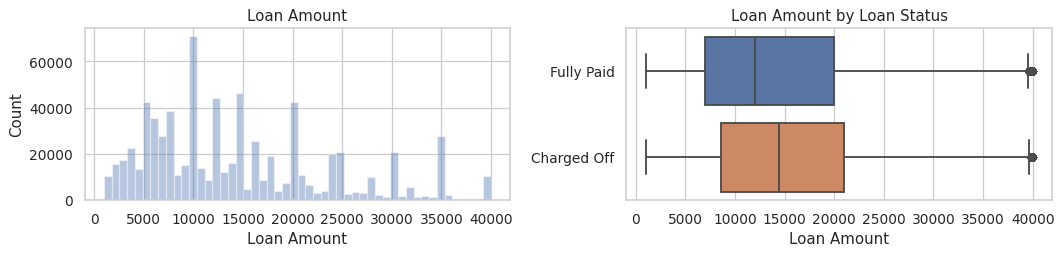

In [35]:
plot_var(loans,'loan_amnt', 'Loan Amount', continuous=True)

### จากผลการวิเคราะห์ด้วย BoxPlot พบว่า Loan Amount ของ Fully Paid และ Charged Off มี median ต่างกันพอสมควร โดย Charged Off มี median ของ Loan Amount ที่สูงกว่ามาก
### ดังนี้แล้วจึงแปรผลได้ว่า การปล่อยกู้ในวงเงินที่สูงขึ้น มีความสัมพันธ์กับ การไม่ชำระเงินคืนอย่างมาก

In [36]:
## ขยายรายละเอียดจาก boxplot ข้างบน

loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,152999.0,15848.418127,9336.441359,1000.0,8550.0,14400.0,21000.0,40000.0
Fully Paid,583755.0,14152.407859,9186.876762,1000.0,7000.0,12000.0,20000.0,40000.0


### **2.2.2 Interest Rate**

In [37]:
## ลบเครื่องหมาย % ออกจากค่าใน int_rate แล้วเปลี่ยน data type ของ int_rate เป็น float64

loans['int_rate'] = loans[['int_rate']].apply(lambda x: x.replace(regex=['%'],value=''))\
.astype('float64')

In [38]:
loans['int_rate'].describe()

count    736754.000000
mean         13.210859
std           5.158126
min           5.310000
25%           9.490000
50%          12.740000
75%          15.990000
max          30.990000
Name: int_rate, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


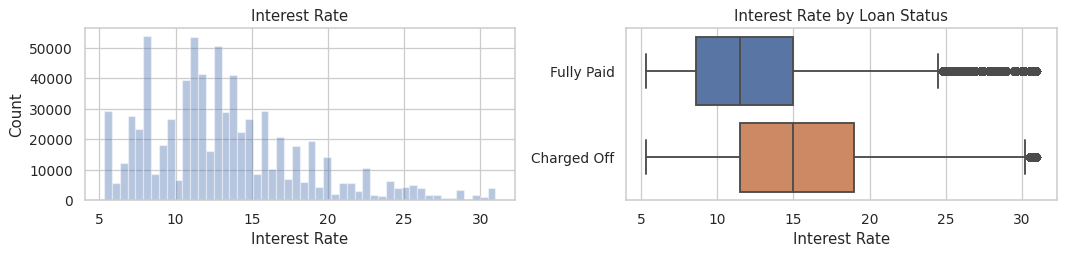

In [39]:
plot_var(loans,'int_rate', 'Interest Rate', continuous=True)

### จากผลการวิเคราะห์ด้วย BoxPlot พบว่า Interest Rate ของ Fully Paid กับ Charged Off มี meean ของ Interest Rate ที่ต่างกันเล็กน้อย
### ดังนี้แล้วจึงแปรผลได้ว่า ดอกเบี้ยเงินกู้ที่แตกต่างกัน มีความสัมพันธ์เกี่ยวข้องกับ การชำระหนี้คืนทั้งหมด หรือไม่ทั้งหมด เพียงเล็กน้อย**

In [40]:
## ขยายรายละเอียดจาก boxplot ข้างบน

loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,152999.0,15.864707,5.451607,5.31,11.49,14.99,18.99,30.99
Fully Paid,583755.0,12.515300,4.843605,5.31,8.59,11.49,14.99,30.99


In [41]:
lowCorrCols_list.append('int_rate')
lowCorrCols_list

['int_rate']

### **2.2.3 Installment**

In [42]:
loans['installment'].describe()

count    736754.000000
mean        446.576084
std         282.946410
min          30.120000
25%         238.110000
50%         370.480000
75%         602.300000
max        1715.420000
Name: installment, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


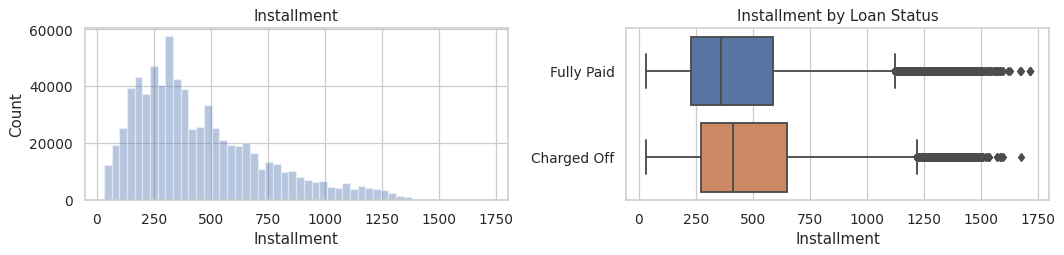

In [43]:
plot_var(loans,'installment', 'Installment', continuous=True)

### จากผลการวิเคราะห์ด้วย BoxPlot พบว่า Installment ของ Fully Paid กับ Charged Off มี mean ของ Installment ที่ต่างกัน
### ดังนี้แล้วจึงแปรผลได้ว่า การผ่อนชำระที่แตกต่างกัน มีความสัมพันธ์เกี่ยวข้องกับ การชำระหนี้คืนทั้งหมด หรือไม่ทั้งหมด อยู่พอสมควร

In [44]:
## ขยายรายละเอียดจาก boxplot ข้างบน

loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,152999.0,486.490664,287.133256,30.12,273.39,413.00,651.25,1676.23
Fully Paid,583755.0,436.114690,280.902528,30.12,229.14,360.08,587.17,1715.42


### **2.2.4 Employment Length**

In [45]:
## แสดงทุกค่าใน emp_length โดยแสดงค่า null ด้วย และมีการจัดเรียงตาม index ก่อนแสดง

loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        49886
10+ years    247496
2 years       68493
3 years       60901
4 years       44489
5 years       45876
6 years       32116
7 years       24839
8 years       28125
9 years       26475
< 1 year      55912
NaN           52146
Name: emp_length, dtype: int64

In [46]:
## แสดงค่าใน emp_length

loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        49886
10+ years    247496
2 years       68493
3 years       60901
4 years       44489
5 years       45876
6 years       32116
7 years       24839
8 years       28125
9 years       26475
< 1 year      55912
NaN           52146
Name: emp_length, dtype: int64

In [47]:
## เปลียน Null ใน emp_length เป็น 'N/A'

loans['emp_length'] = loans[['emp_length']].apply( lambda x:x.replace(to_replace=np.nan, value='N/A'))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


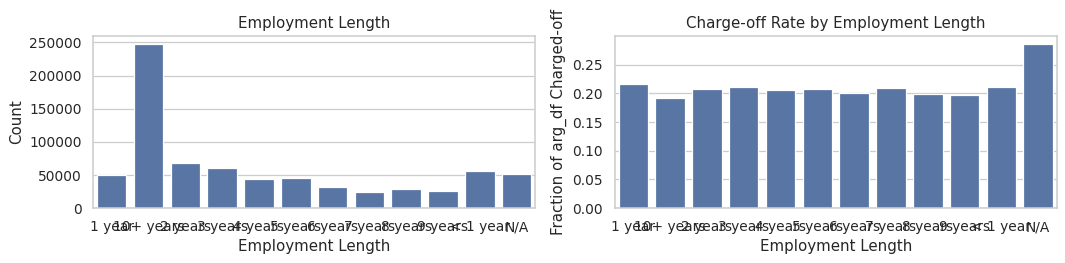

In [48]:
plot_var(loans,'emp_length', 'Employment Length', continuous=False)

### จากผลการวิเคราะห์ด้วย Bar Chart พบว่า Charged off ดูไม่แตกต่างกันในระยะเวลาเวลาการจ้างงาน (emp_length) โดยส่วนใหญ่
### แต่ ค่า Null ในระยะเวลาการจ้างงาน ('N/A') มี Charged off สูงแตกต่างจากระยะเวลาการจ้างงานอื่นๆ 
### ดังนี้จึงแปลผลได้ว่า การไม่ระบุระยะเวลาการจ้าง มีสัมพันธ์กับการไม่จ่ายหนี้คืน **

In [49]:
highCorrCols_list.append('emp_length')
highCorrCols_list

['emp_length']

### **2.2.5 Annual Income**

In [50]:
loans['annual_inc'].describe()

count    7.367540e+05
mean     7.949849e+04
std      7.809475e+04
min      0.000000e+00
25%      4.800000e+04
50%      6.700000e+04
75%      9.500000e+04
max      9.573072e+06
Name: annual_inc, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


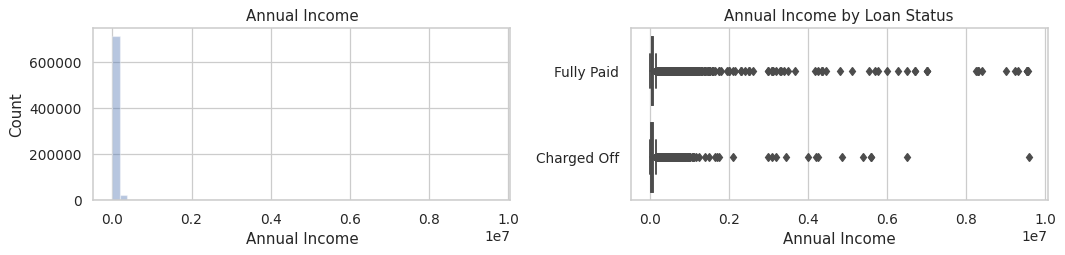

In [51]:
plot_var(loans,'annual_inc', 'Annual Income', continuous=True)

### จากผลการวิเคราะห์ด้วยเทคนิค boxplot ยังไม่สามารถอ่านผลที่ชัดเจนในด้านความพันธ์ 
### แต่จาก upper-fencing ของ boxplot พบว่า มี data points ของ annual_inc ที่สูงกว่า upper-fencing เป็นจำนวนมาก
### เช่นนี้แปลผลได้ว่า annual_inc มี outlier จำนวนมากแฝงอยู่ในข้อมูล **

In [52]:
max_annual_inc = loans['annual_inc'].max()

In [53]:
min_annual_inc = loans['annual_inc'].min()

In [54]:
loans['annual_inc'] = loans['annual_inc'].apply(lambda x: ((x-min_annual_inc)/(max_annual_inc-min_annual_inc)))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


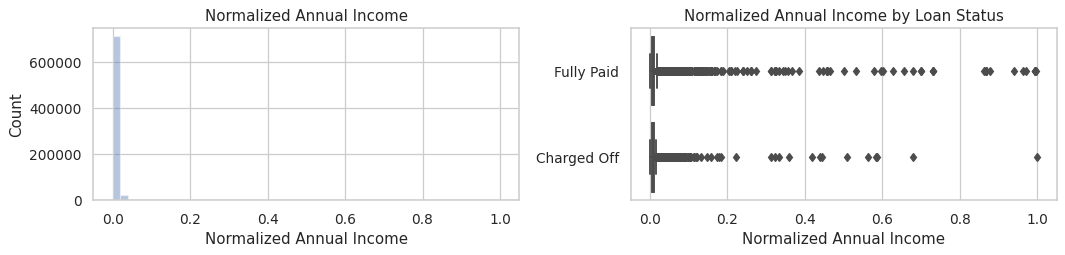

In [55]:
plot_var(loans,'annual_inc', 'Normalized Annual Income', continuous=True)

In [56]:
loans['annual_inc'].describe()

count    736754.000000
mean          0.008304
std           0.008158
min           0.000000
25%           0.005014
50%           0.006999
75%           0.009924
max           1.000000
Name: annual_inc, dtype: float64

In [57]:
#outlierCols_list.append('annual_inc')
outlierCols_list

[]

### **2.2.6 Debt to Income**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


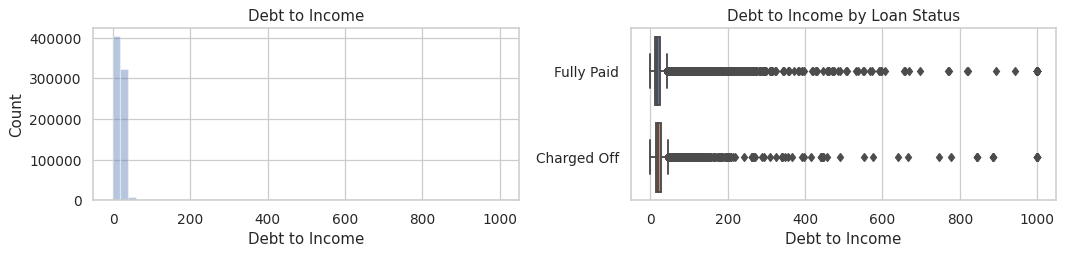

In [58]:
plot_var(loans,'dti', 'Debt to Income', continuous=True)

### จากผลการวิเคราะห์ด้วยเทคนิค boxplot ยังไม่สามารถอ่านผลที่ชัดเจนในด้านความพันธ์ 
### แต่จาก upper-fencing ของ boxplot พบว่า มี data points ของ dti ที่สูงกว่า upper-fencing เป็นจำนวนมาก
### เช่นนี้แปลผลได้ว่า dti มี outlier จำนวนมากแฝงอยู่ในข้อมูล **

In [59]:
outlierCols_list.append('dti')
outlierCols_list

['dti']

### **2.2.7 delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.**

In [60]:
numCol_list

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'total_pymnt', 'total_pymnt_inv'],
      dtype='object')

In [61]:
catCol_list

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'debt_settlement_flag'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


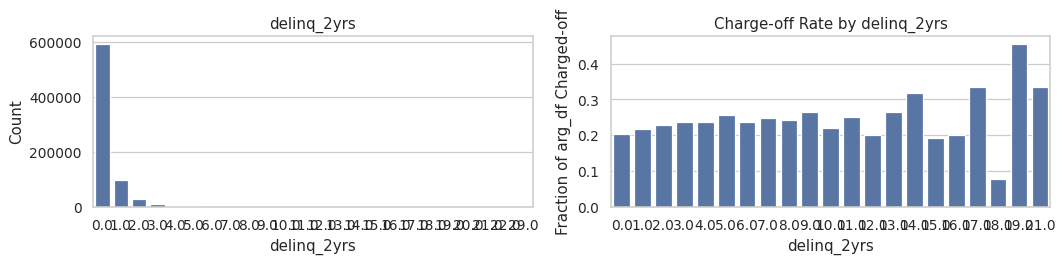

In [62]:
plot_var(loans,'delinq_2yrs', 'delinq_2yrs', continuous=False)

In [63]:
loans['delinq_2yrs'].value_counts()

0.0     591859
1.0      96038
2.0      27914
3.0      10275
4.0       4729
5.0       2370
6.0       1396
7.0        777
8.0        437
9.0        293
10.0       236
11.0       140
12.0        95
13.0        49
14.0        44
15.0        31
16.0        20
18.0        13
19.0        11
20.0        10
17.0         9
21.0         6
22.0         1
29.0         1
Name: delinq_2yrs, dtype: int64

In [64]:
outlierCols_list.append('delinq_2yrs')
outlierCols_list

['dti', 'delinq_2yrs']

### **2.2.8 revol.util: The borrower’s revolving line utilization rate (the amount of the credit line used relative to total credit available).**

In [65]:
loans['revol_util'] = loans[['revol_util']].apply(lambda x: x.replace(to_replace=np.nan,value='N/A'))

In [66]:
#plot_var(loans,'revol_util', 'revol_util', continuous=False)

In [67]:
#categorical = list(loans.select_dtypes('object').columns)

#numerical = list(loans.select_dtypes('number').columns) 

In [68]:
#categorical

In [69]:
#numerical

In [70]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736754 entries, 0 to 1432462
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             736754 non-null  float64
 1   funded_amnt           736754 non-null  float64
 2   funded_amnt_inv       736754 non-null  float64
 3   term                  736754 non-null  object 
 4   int_rate              736754 non-null  float64
 5   installment           736754 non-null  float64
 6   grade                 736754 non-null  object 
 7   sub_grade             736754 non-null  object 
 8   emp_title             681958 non-null  object 
 9   emp_length            736754 non-null  object 
 10  home_ownership        736754 non-null  object 
 11  annual_inc            736754 non-null  float64
 12  verification_status   736754 non-null  object 
 13  issue_d               736754 non-null  object 
 14  loan_status           736754 non-null  object 
 15 

# **3. Feature Engineering and Feature Selection**

## **3.1 สร้าง Dummy Variables/Columns**

In [71]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [72]:
loans['charged_off'].value_counts()

0    583755
1    152999
Name: charged_off, dtype: int64

In [73]:
## สร้าง dummy vars./cols. 

tobeDummy_columns = ["grade","emp_length","home_ownership", "verification_status", "purpose", "term"]
dummy_df = pd.get_dummies(loans[tobeDummy_columns])
loans = pd.concat([loans, dummy_df], axis=1)
loans = loans.drop(tobeDummy_columns, axis=1)

In [74]:
## แสดงรายชื่อ cols หลังจากเพิ่ม dummy vars./cols.

pd.DataFrame(loans.columns.sort_values())

,0
0,addr_state
1,annual_inc
2,application_type
3,charged_off
4,debt_settlement_flag
5,delinq_2yrs
6,dti
7,earliest_cr_line
8,emp_length_1 year
9,emp_length_10+ years


In [75]:
print('columns หลังจากเพิ่ม dummy vars./cols. มีจำนวน: %2d'%(len(loans.axes[1].values)))

columns หลังจากเพิ่ม dummy vars./cols. มีจำนวน: 72


------------------------------สิ่งที่ได้รับตอนนี้ คือ ชื่อ Dummy Variables (ผ่านการทำ Encoding)------------------------------

### **3.2 Feature Selection**

In [76]:

print(nullCols_list)

print(outlierCols_list)

print(highScaleCols_list)

print(highDispersionCols_list)

print(highCorrCols_list)

print(lowCorrCols_list)

print(numCol_list)

print(catCol_list)

['emp_title', 'emp_length', 'title', 'zip_code', 'dti', 'revol_util', 'last_pymnt_d', 'last_credit_pull_d']
['dti', 'delinq_2yrs']
[]
['delinq_2yrs', 'pub_rec', 'revol_bal']
['emp_length']
['int_rate']
Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'total_pymnt', 'total_pymnt_inv'],
      dtype='object')
Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'debt_settlement_flag'],
      dtype='object')


In [77]:
# *** finally drop columns

loans = loans.drop('revol_util',axis=1)\
.drop(['dti',
 'open_acc',
 'revol_bal'],axis=1)\
 .drop([x for x in loans.axes[1].values.tolist() if 'purpose_' in x],axis=1)\
 .drop([x for x in loans.axes[1].values.tolist() if '_pymnt' in x],axis=1)\
 .drop([x for x in loans.axes[1].values.tolist() if 'num_' in x],axis=1)\
 .drop([x for x in loans.axes[1].values.tolist() if 'funded_' in x],axis=1)\
 .drop(temp_IgnoredCols_list,errors='ignore',axis=1)\
 .drop(outlierCols_list,errors='ignore',axis=1)\
 .drop([x for x in loans.axes[1].values.tolist() if 'term_' in x],errors='ignore',axis=1)

------------------------------สิ่งที่ได้รับตอนนี้ คือ ชื่อ Feature ที่คาดว่ามีความสัมพันธ์กับ Label------------------------------

## **3.2 สร้าง Training Set และ Testing Set**

In [78]:
loans['issue_d'].sample(5)

243574     Sep-2016
136161     Jun-2016
1239526    Nov-2018
524274     Jan-2017
119617     Jan-2016
Name: issue_d, dtype: object

In [79]:
loans['issue_d'].isnull().any()

False

In [80]:
## เปลี่ยน data type ของ issue_d เป็น datetime
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [81]:
loans['issue_d'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  736754
unique                     30
top       2017-03-01 00:00:00
freq                    86864
first     2016-01-01 00:00:00
last      2019-03-01 00:00:00
Name: issue_d, dtype: object

Text(0.5, 1.0, 'Loans Funded per Year')

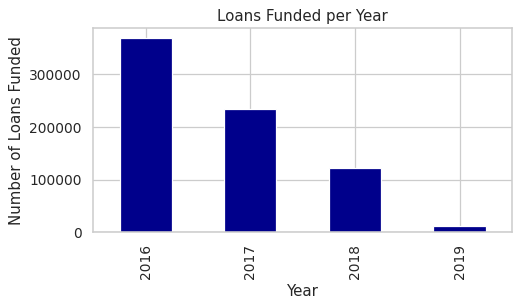

In [82]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

In [83]:
# สร้าง training set และ testing set ซึ่งเป็นแบบ Hand-out testing set
# โดยข้อมูลที่เก่ากว่า issue_d ที่ quantile 0.9 ถูกนำมาสุ่มเลือกเพื่อเป็น training set
# ส่วนข้อมูลที่ใหม่กว่าฯ ถูกนำมาสุ่มเลือกเพื่อเป็น testing set
loans_train = loans.loc[loans['issue_d'] < loans['issue_d'].quantile(0.9)].sample(300000).dropna() 
loans_test = loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)].sample(10000).dropna()

In [84]:
# นับจำนวน Fully Paid หรือ Charged Off 
# ผลการนับพบว่า มีจำนวน Fully Paid กับ Charged Off ต่างกันค่อนข้างมาก
# ความต่างกันลักษณะนี้ เรียกว่า "Imbalance Classes"

charged_off_pd = loans_train[loans_train['charged_off'] == 1]
fully_paid_pd = loans_train[loans_train['charged_off'] == 0]
print(charged_off_pd.shape)
print(fully_paid_pd.shape)

(55449, 47)
(215671, 47)


In [85]:
# แก้ไข Imbalance Classes ด้วยการ upsampling เฉพาะ Charge Off

from sklearn.utils import resample
fullyPaid_downsample = resample(fully_paid_pd,
             replace=True,
             n_samples=len(charged_off_pd),
             random_state=42)

print(fullyPaid_downsample.shape)

(55449, 47)


In [86]:
#Merge rows ที่เป็น Fully Paid และ Charge Off ที่ผ่านการทำ upsampling แล้ว เข้าด้วยกัน

loans_train = pd.concat([fullyPaid_downsample, charged_off_pd])
print(loans_train[loans_train['charged_off']==1].shape)
print(loans_train[loans_train['charged_off']==0].shape)

(55449, 47)
(55449, 47)


In [87]:
print('Number of loans in the training and testing set:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the training and testing set:    119789
Number of loans in the full dataset: 736754


In [88]:
loans_test.shape[0]

8891

In [89]:
loans_test.shape[0] / loans.shape[0]

0.012067800106955646

In [90]:
## แสดงให้เห็นว่า ข้อมูลที่เอามา Train ไม่เคยอยู่ใน Test

loans_train['issue_d'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                  110898
unique                     19
top       2017-03-01 00:00:00
freq                    15477
first     2016-01-01 00:00:00
last      2018-04-01 00:00:00
Name: issue_d, dtype: object

In [91]:
## แสดงให้เห็นว่า ข้อมูลที่เอามา Test ไม่เคยอยู่ใน Train

loans_test['issue_d'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                    8891
unique                     11
top       2018-05-01 00:00:00
freq                     1517
first     2018-05-01 00:00:00
last      2019-03-01 00:00:00
Name: issue_d, dtype: object

In [92]:
loans_train = loans_train.drop('issue_d',axis=1)
loans_test = loans_test.drop('issue_d',axis=1)

In [93]:
y_train = loans_train['charged_off']
y_test = loans_test['charged_off']

In [94]:
X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

------------------------------สิ่งที่ได้รับตอนนี้ Training set และ Testing set เก็บอยู่ในตัวแปรทั้งหมด 4 ตัว------------------------------

## **3.3 Feature Selection on Training Set using Bar Chart**

In [95]:
def feature_plot_var(arg_df, col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(arg_df.loc[arg_df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(arg_df[col_name], order=sorted(arg_df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='charged_off', data=arg_df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = arg_df.groupby(col_name)['charged_off'].value_counts(normalize=True).loc[:,1]
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of arg_df Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

In [96]:
loans.select_dtypes('number').columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'pub_rec',
       'total_acc', 'charged_off', 'grade_A', 'grade_B', 'grade_C', 'grade_D',
       'grade_E', 'grade_F', 'grade_G', 'emp_length_1 year',
       'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
       'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
       'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years',
       'emp_length_< 1 year', 'emp_length_N/A', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object')

In [97]:
corrTestCols_list = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'pub_rec',
       'total_acc','charged_off']

In [98]:
# Plot
#plt.figure(figsize=(10,8), dpi= 80)
#sns.pairplot(loans[corrTestCols_list], kind="scatter", hue="charged_off", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
#plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

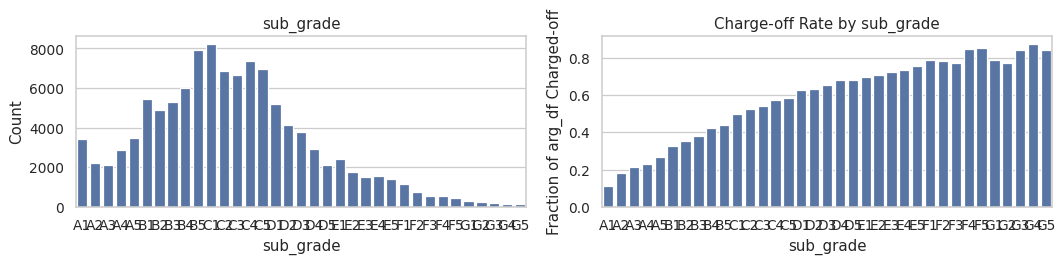

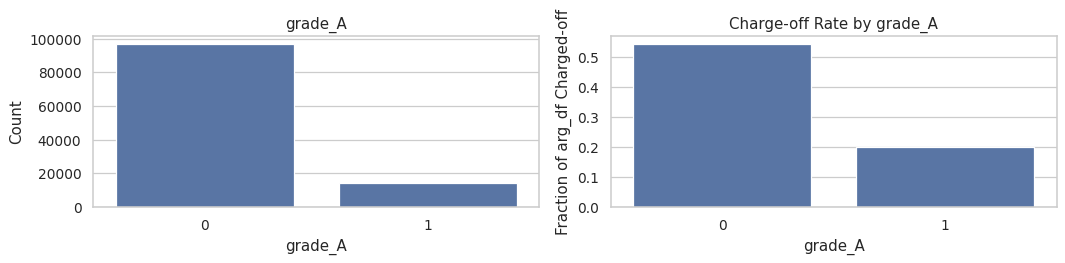

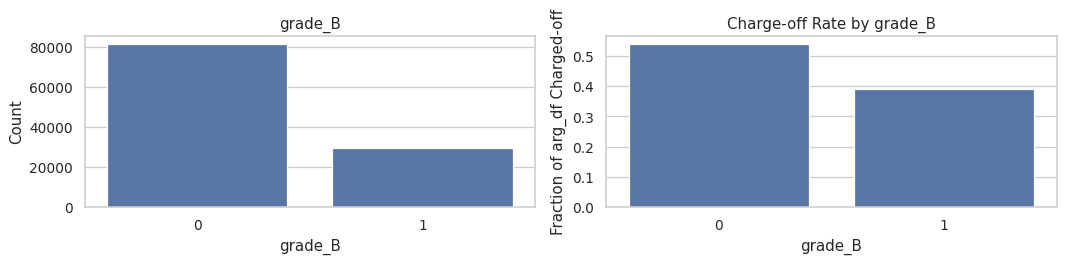

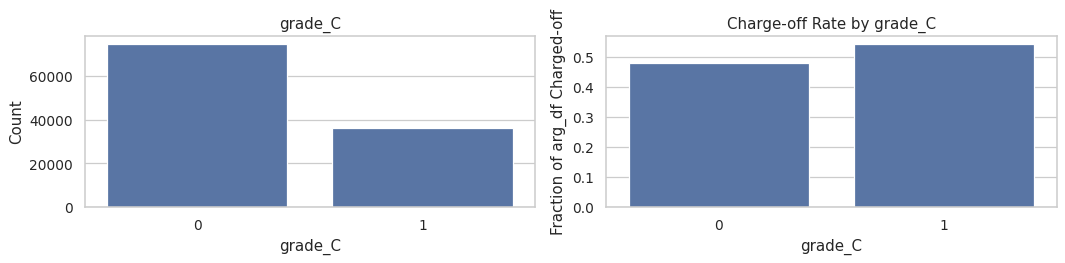

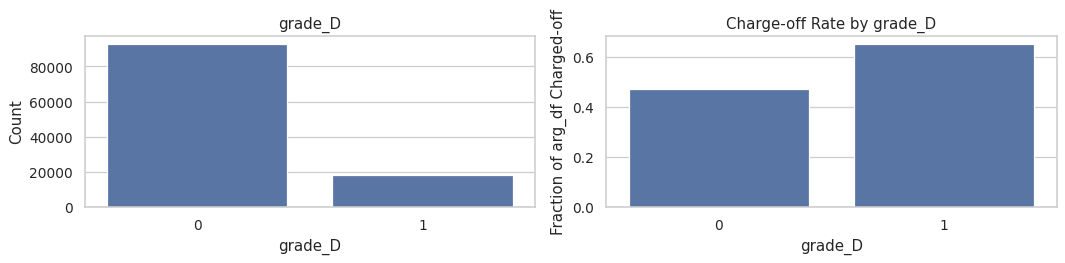

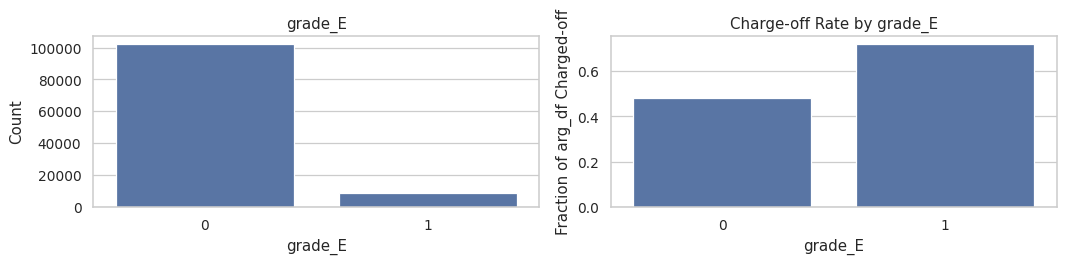

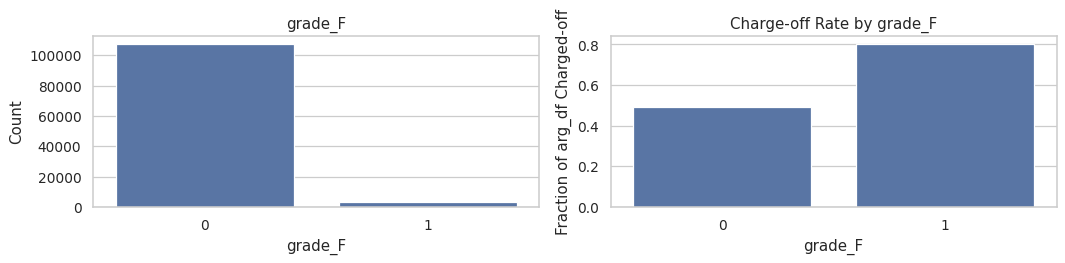

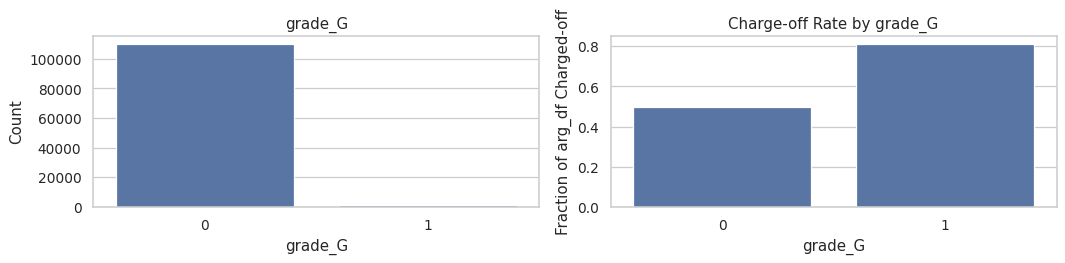

In [99]:
for testCol in [x for x in loans_train.axes[1].values.tolist() if 'grade' in x]:
  feature_plot_var(loans_train,testCol, testCol, continuous=False)

In [100]:
for testCol in [x for x in loans_train.axes[1].values.tolist() if 'delinq_2yrs' in x]:
  feature_plot_var(loans_train,testCol, testCol, continuous=False)

In [101]:
#for testCol in [x for x in loans_train.axes[1].values.tolist() if 'inq_last_6mths' in x]:
  #feature_plot_var(loans_train,testCol, testCol, continuous=False)

In [102]:
#for testCol in [x for x in loans_train.axes[1].values.tolist() if 'open_acc' in x]:
  #feature_plot_var(loans_train,testCol, testCol, continuous=True)

In [103]:
#for testCol in [x for x in loans_train.axes[1].values.tolist() if 'revol_bal' in x]:
  #feature_plot_var(loans_train,testCol, testCol, continuous=True)

In [104]:
#for testCol in [x for x in loans_train.axes[1].values.tolist() if 'total_acc' in x]:
  #feature_plot_var(loans_train,testCol, testCol, continuous=True)

In [105]:
#for testCol in [x for x in loans_train.axes[1].values.tolist() if 'dti' in x]:
  #feature_plot_var(loans_train,testCol, testCol, continuous=True)

In [106]:
#for testCol in [x for x in loans_train.axes[1].values.tolist() if 'pub_rec' in x]:
  #feature_plot_var(loans_train,testCol, testCol, continuous=False)

In [107]:
for testCol in [x for x in loans_train.axes[1].values.tolist() if 'term_' in x]:
  feature_plot_var(loans_train,testCol, testCol, continuous=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

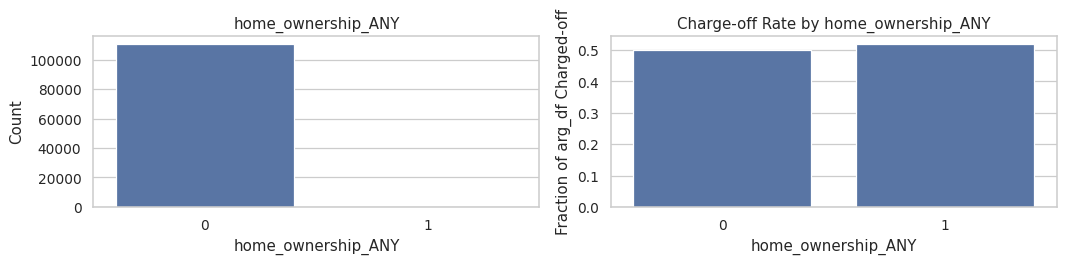

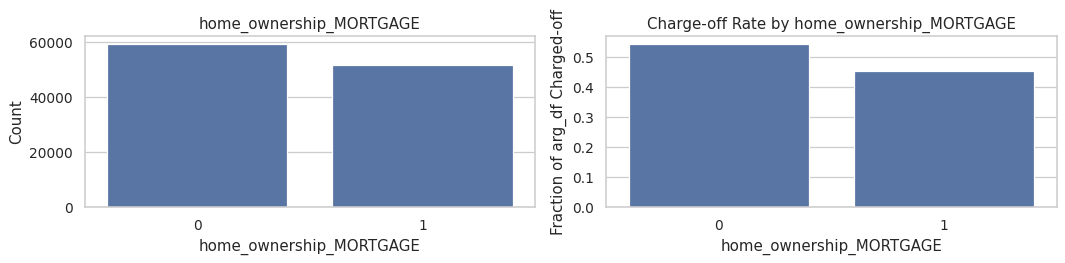

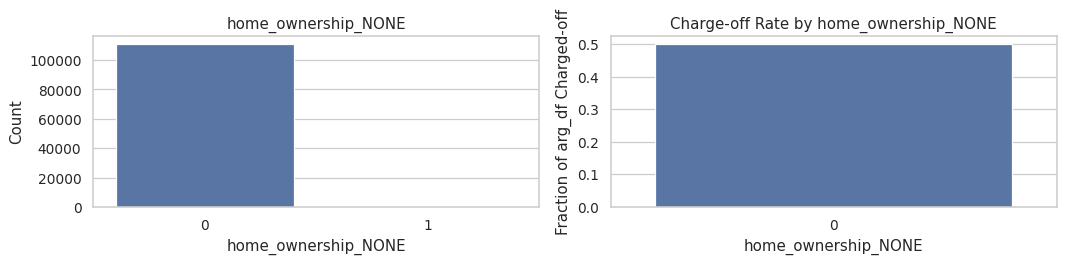

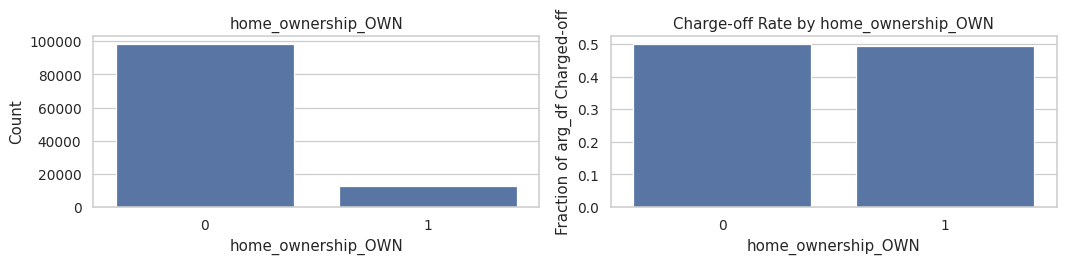

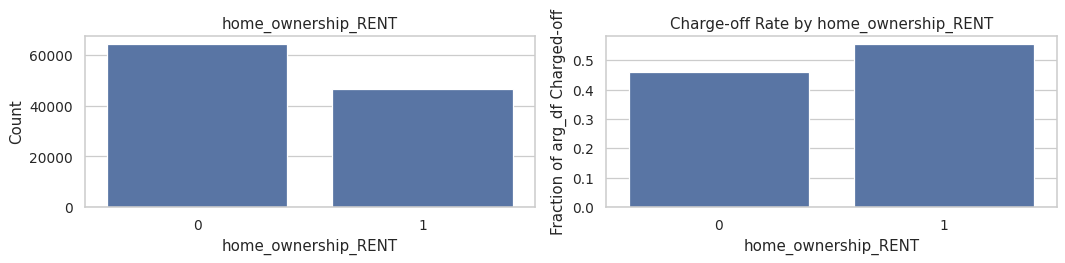

In [108]:
for testCol in [x for x in loans_train.axes[1].values.tolist() if 'home_' in x]:
  feature_plot_var(loans_train,testCol, testCol, continuous=False)

In [109]:
#for testCol in [x for x in loans_train.axes[1].values.tolist() if 'purpose_' in x]:
  #feature_plot_var(loans_train,testCol, testCol, continuous=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


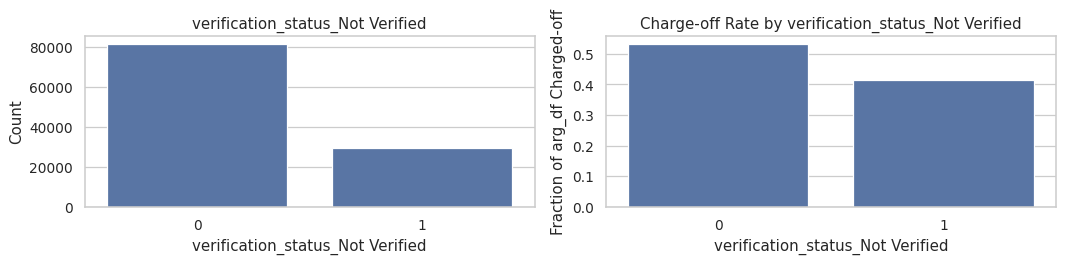

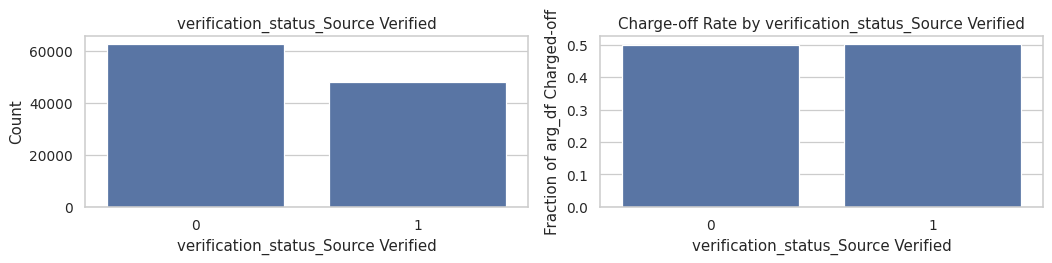

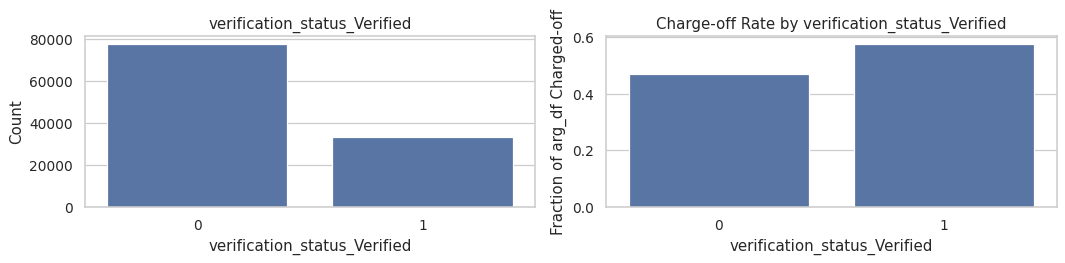

In [110]:
for testCol in [x for x in loans_train.axes[1].values.tolist() if 'verification_' in x]:
  feature_plot_var(loans_train,testCol, testCol, continuous=False)

In [111]:
loans_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110898 entries, 260203 to 156080
Data columns (total 46 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            110898 non-null  float64
 1   int_rate                             110898 non-null  float64
 2   installment                          110898 non-null  float64
 3   sub_grade                            110898 non-null  object 
 4   emp_title                            110898 non-null  object 
 5   annual_inc                           110898 non-null  float64
 6   pymnt_plan                           110898 non-null  object 
 7   title                                110898 non-null  object 
 8   zip_code                             110898 non-null  object 
 9   addr_state                           110898 non-null  object 
 10  earliest_cr_line                     110898 non-null  object 
 11  pub_rec 

In [112]:
## ทดสอบเกณฑ์การประเมิน

import pandas as pd
import numpy as np
predictions = pd.Series(np.ones(loans.shape[0])) ## สร้าง prediction แบบ series ขึ้นมารับค่า 1 ตามจำนวน row ของ loans โดยสมมติว่า prediction เป็น charged off ทั้งหมด
# False positives.
fp_filter = (predictions == 1) & (loans["charged_off"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["charged_off"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["charged_off"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["charged_off"] == 0)
tn = len(predictions[tn_filter])



In [113]:
## ผลการทดสอบเครื่องมือเฉพาะด้าน Positive Side - เฉพาะรายที่ Charged Off
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(tpr)
print(fpr)



1.0
1.0


In [114]:
# สรุป ABT 
print ('จำนวน Training set เฉพาะ Features: %1d rows'%(len(X_train)))

print ('จำนวน Training set เฉพาะ Label: %1d rows'%(len(y_train))) 

print ('จำนวน Testing set เฉพาะ Features: %1d rows'%(len(X_test)))

print ('จำนวน Testing set เฉพาะ Label: %1d rows'%(len(y_test)))



จำนวน Training set เฉพาะ Features: 110898 rows
จำนวน Training set เฉพาะ Label: 110898 rows
จำนวน Testing set เฉพาะ Features: 8891 rows
จำนวน Testing set เฉพาะ Label: 8891 rows


In [115]:
#del loans_train, loans_test

In [116]:
#del loans

# **4. Modeling and Evaluation**

In [117]:
# สรุป Feature ใน Training set
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110898 entries, 260203 to 156080
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            110898 non-null  float64
 1   int_rate                             110898 non-null  float64
 2   installment                          110898 non-null  float64
 3   sub_grade                            110898 non-null  object 
 4   emp_title                            110898 non-null  object 
 5   annual_inc                           110898 non-null  float64
 6   pymnt_plan                           110898 non-null  object 
 7   title                                110898 non-null  object 
 8   zip_code                             110898 non-null  object 
 9   addr_state                           110898 non-null  object 
 10  earliest_cr_line                     110898 non-null  object 
 11  pub_rec 

In [118]:
# สรุป Label เฉพาะ Charge Off ใน Training set

len(y_train[y_train==1])

55449

In [119]:
# สรุป Label เฉพาะ Fully Paid ใน Training set

len(y_train[y_train==0])

55449

In [120]:
#X_train.columns.tolist()

In [121]:
import pandas as pd
from seaborn import load_dataset
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [122]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [123]:
# รวบรวมชื่อ Column ที่เป็น String เก็บไว้ในตัวแปรชื่อ categorical
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

# รวบรวมชื่อ Column ที่เป็น numerical เก็บไว้ในตัวแปรชื่อ numerical
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['sub_grade', 'emp_title', 'pymnt_plan', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'debt_settlement_flag']
Numerical columns are: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'pub_rec', 'total_acc', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year', 'emp_length_N/A', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified']


## **4.1 Logistic Regression**

In [124]:
# เลือกเฉพาะ Numerical variables มาเป็น Feature
# แล้วส่ง Feature เก็บไว้ในตัวแปรชื่อ features
features = X_train

# ส่ง Label เก็บไว้ในตัวแปรชื่อ target
target = y_train

In [125]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110898 entries, 260203 to 156080
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            110898 non-null  float64
 1   int_rate                             110898 non-null  float64
 2   installment                          110898 non-null  float64
 3   sub_grade                            110898 non-null  object 
 4   emp_title                            110898 non-null  object 
 5   annual_inc                           110898 non-null  float64
 6   pymnt_plan                           110898 non-null  object 
 7   title                                110898 non-null  object 
 8   zip_code                             110898 non-null  object 
 9   addr_state                           110898 non-null  object 
 10  earliest_cr_line                     110898 non-null  object 
 11  pub_rec 

In [126]:
categorical.remove('debt_settlement_flag');categorical

['sub_grade',
 'emp_title',
 'pymnt_plan',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag']

In [127]:
categorical.remove('hardship_flag');categorical

['sub_grade',
 'emp_title',
 'pymnt_plan',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_credit_pull_d',
 'application_type']

In [128]:
categorical.remove('last_credit_pull_d');categorical

['sub_grade',
 'emp_title',
 'pymnt_plan',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type']

In [129]:
categorical.remove('earliest_cr_line');categorical

['sub_grade',
 'emp_title',
 'pymnt_plan',
 'title',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type']

In [130]:
categorical.remove('zip_code');categorical

['sub_grade',
 'emp_title',
 'pymnt_plan',
 'title',
 'addr_state',
 'initial_list_status',
 'application_type']

In [131]:
categorical.remove('initial_list_status');categorical

['sub_grade',
 'emp_title',
 'pymnt_plan',
 'title',
 'addr_state',
 'application_type']

In [132]:
categorical.remove('application_type');categorical

['sub_grade', 'emp_title', 'pymnt_plan', 'title', 'addr_state']

In [133]:
categorical.remove('addr_state');categorical

['sub_grade', 'emp_title', 'pymnt_plan', 'title']

In [134]:
categorical.remove('title');categorical

['sub_grade', 'emp_title', 'pymnt_plan']

In [135]:
categorical.remove('emp_title');categorical

['sub_grade', 'pymnt_plan']

In [136]:
categorical.remove('pymnt_plan');categorical

['sub_grade']

In [137]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer



# Define custom transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# Define categorical pipeline
cat_pipe = Pipeline([('selector', ColumnSelector(categorical)),
                     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([('selector', ColumnSelector(numerical))
                     #('imputer', SimpleImputer(strategy='median')),
                     #('scaler', MinMaxScaler())
                    ])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion(transformer_list=[('cat', cat_pipe),
                                              ('num', num_pipe)])

# Model Training
pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('model', LogisticRegression())])
pipeline_model = pipe.fit(features, target)

In [138]:
from sklearn.metrics import confusion_matrix

# การนำ pipeline_model มา make prediction โดยค่าที่ predict ถูกเก็บไว้ใน y_pred
y_pred = pipeline_model.predict(X_test).flatten()

# นำค่าที่ predict (y_pred) มาเปรียบเทียบกับค่าจริงที่อยู่ใน y_test
cm = confusion_matrix(y_test,y_pred)

# สรุปผลการเปรียบเทียบด้วย Confusion Matrix
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,4661,2836,7497
1,463,931,1394
All,5124,3767,8891


In [139]:
from sklearn.metrics import confusion_matrix

# นำผลการเปรียบเทียบมาคำนวณ เพื่อประเมินตามเกณฑ์
#cm = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix (predict/actual):\n", pd.DataFrame(cm))
pipeline_model.score(X_test, y_test)


#เกณฑ์ recall
recall = np.diag(cm) / np.sum(cm, axis=1)
print("\nRecall:\n", pd.Series(recall))

#เกณฑ์ precision
precision = np.diag(cm) / np.sum(cm, axis=0)
print("\nPrecision:\n", pd.Series(precision))

#เกณฑ์ f1
from sklearn.metrics import f1_score
weighted_f1 = f1_score(y_test, y_pred, average="weighted")
print("\nF1 score:\n", weighted_f1)


Recall:
 0    0.621715
1    0.667862
dtype: float64

Precision:
 0    0.909641
1    0.247146
dtype: float64

F1 score:
 0.6793715307358771


In [140]:
# ลบโมเดล lr

del pipeline_model